In [1]:
import keras
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

2023-10-31 23:12:57.530262: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-31 23:12:57.556213: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 23:12:57.556230: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 23:12:57.556260: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-31 23:12:57.561643: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-31 23:12:57.562077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

57026/57026 [==============================] - 0s 1us/step


In [2]:
print(train_data.shape) #matrux 404 rows and 13 columns
print(train_data[0]) #floats all the way
print(train_targets[0]) #float value

(404, 13)
[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
15.2


In [5]:
#we are dealing with numbers only
#we want to normalize the data
#feature-wise normalization:
#for each feature we subtract the mean of the feature and divide by its std. deviation

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data -= mean
train_data /= std

#NOTE: we use the mean and std from the training data
#we know anything of the test data!
test_data -= mean
test_data /= std

In [9]:
from keras import layers

def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(
        optimizer='rmsprop',
        loss='mse', #mean square error best for regressions
        metrics=['mae'] #mean absolute error best for regressions
    )
    return model

In [14]:
#since we have few datapoints (400 and something)
#the approach of splitting dataset into training and validation set is not good
#since val acc will depends a lot on the points used... thats why we use k-fold validation!
import numpy as np

def k_fold_validation(k, epochs, train_data=train_data, train_targets=train_targets):
    all_mae_histories = []
    num_val_samples = len(train_data) // k
    all_scores = []
    for i in range(k):
        print(f"Processing fold #{i}")
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
        partial_train_data = np.concatenate(
            [train_data[:i * num_val_samples],
            train_data[(i + 1) * num_val_samples:]],
            axis=0
        )
        partial_train_targets = np.concatenate(
            [train_targets[:i * num_val_samples],
            train_targets[(i + 1) * num_val_samples:]],
            axis=0
        )
        model = build_model()
        history = model.fit(partial_train_data, partial_train_targets,epochs=epochs, validation_data=(val_data, val_targets), batch_size=16, verbose=0)
        all_mae_histories.append(history.history["val_mae"])
        val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
        all_scores.append(val_mae)
    return np.mean(all_scores), all_mae_histories

In [21]:
(mae_mean, all_mae_history) = k_fold_validation(5, 300, train_data)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


TypeError: unsupported operand type(s) for /: 'generator' and 'int'

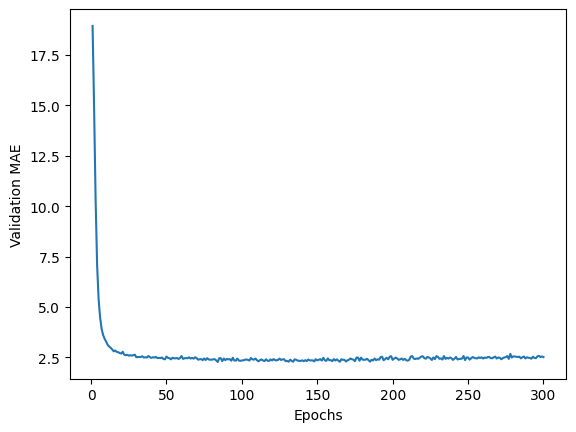

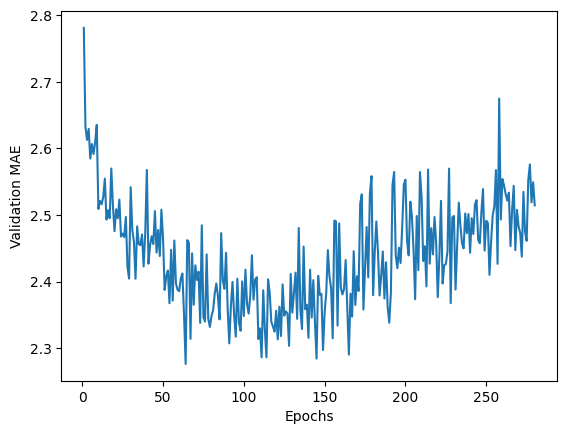

In [25]:
#plotting of the avg_mae_history
avg_mae_history = [np.mean([x[i] for x in all_mae_history]) for i in range(300)]

import matplotlib.pyplot as plt
plt.plot(range(1, len(avg_mae_history) + 1), avg_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

#we truncate the array to have a better graph
plt.plot(range(1, len(avg_mae_history[20:]) + 1), avg_mae_history[20:])
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

#from the pic we can see that mae is best at 60ish epochs (+20 that we removed means 80ish)
#after it starts to be unstable....

In [27]:
model = build_model()
model.fit(train_data, train_targets, epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score #we are off by test_mae_score

4/4 [==============================] - 0s 1ms/step - loss: 14.9310 - mae: 2.4942


2.49415922164917